# 06 - Classificando patologias em toras usando combinação de `OTSU_treshold + LBP + SVM` e normalizando amostras pela soma de cada elemento do histograma

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from zipfile import ZipFile
from skimage import io
from skimage.filters import threshold_otsu
from skimage.feature import local_binary_pattern

# Parâmetros do LBP
METHOD = 'nri_uniform'
RADIUS = 1
N_POINTS = 8

TARGET_NAMES = {'normal': 0,
                'broca':1,
                'fissura': 2,
                'musgo': 3}

## Processando imagens

In [2]:
path_dict = {name: [] for name in TARGET_NAMES}

with ZipFile('./patologias_toras.zip') as zip_file:
  for path in zip_file.namelist():
    # a pasta de cada amostra é o segundo elemento do split
    folder = path.split('/')[1]
    # Separando amostras por classe
    if folder in TARGET_NAMES:
      path_dict[folder].append(f'./patologias_toras.zip/{path}')


# Mostrando quantidade de amostras por classe
qtd_amostras_p_classe = []
for target in path_dict:
  n_amostras = len(path_dict[target])
  print(f'{target}: {n_amostras} amostras')

  qtd_amostras_p_classe.append(n_amostras)

N_MIN_DE_AMOSTRAS = min(qtd_amostras_p_classe)
amostra = []

for target_name in TARGET_NAMES:
  path_list = path_dict[target_name]
  path_list_slice = path_list[:N_MIN_DE_AMOSTRAS]
  
  for path in path_list_slice:
    img = io.imread(path, as_gray=True)
    
    img_otsu = img >= threshold_otsu(img)

    lbp = local_binary_pattern(image=img_otsu, P=N_POINTS, R=RADIUS, method=METHOD).flatten()
    
    hist = pd.Series(lbp).value_counts().sort_index()
    arr = np.zeros(59)
    for i in hist.index:
      arr[int(i)] = hist[i]

    # Realizando normalização pelo maior elemento do histograma
    arr /= arr.sum()

    df = pd.DataFrame(data=[arr])
    df['target'] = TARGET_NAMES[target_name]
    amostra.append(df)

data = pd.concat(amostra, ignore_index=True)
data.to_csv('./csvs/otsu_lbp_norm3_toras.csv')
data

normal: 107 amostras
broca: 90 amostras
fissura: 109 amostras
musgo: 111 amostras


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,target
0,0.004063,0.004706,0.0,0.004355,0.0,0.005065,0.0,0.004281,0.0,0.0,...,0.0,0.003543,0.0,0.003511,0.0,0.003532,0.0,0.866764,0.031688,0
1,0.003519,0.004500,0.0,0.004050,0.0,0.004563,0.0,0.003742,0.0,0.0,...,0.0,0.008814,0.0,0.007903,0.0,0.007989,0.0,0.776488,0.048305,0
2,0.003567,0.004862,0.0,0.003211,0.0,0.004885,0.0,0.003059,0.0,0.0,...,0.0,0.005401,0.0,0.005750,0.0,0.005122,0.0,0.835412,0.036268,0
3,0.002983,0.005199,0.0,0.004436,0.0,0.005238,0.0,0.004172,0.0,0.0,...,0.0,0.009336,0.0,0.009732,0.0,0.009251,0.0,0.745978,0.052054,0
4,0.003227,0.005966,0.0,0.005349,0.0,0.005908,0.0,0.005173,0.0,0.0,...,0.0,0.009814,0.0,0.010398,0.0,0.010054,0.0,0.705719,0.064854,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.002471,0.004380,0.0,0.003594,0.0,0.004661,0.0,0.002752,0.0,0.0,...,0.0,0.011849,0.0,0.012073,0.0,0.010389,0.0,0.739611,0.029593,3
356,0.000784,0.001330,0.0,0.001440,0.0,0.001476,0.0,0.001695,0.0,0.0,...,0.0,0.011263,0.0,0.013286,0.0,0.011391,0.0,0.795436,0.018171,3
357,0.000851,0.001586,0.0,0.001006,0.0,0.001663,0.0,0.001044,0.0,0.0,...,0.0,0.004255,0.0,0.005454,0.0,0.003133,0.0,0.866945,0.010443,3
358,0.004444,0.005124,0.0,0.004179,0.0,0.005109,0.0,0.004208,0.0,0.0,...,0.0,0.004326,0.0,0.004533,0.0,0.004282,0.0,0.846969,0.026475,3


In [3]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             f1_score,
                             plot_confusion_matrix)

## Realizando 30 rodadas de classificação

Rodada 0	-	Seed 2164
              precision    recall  f1-score   support

      normal       0.87      0.87      0.87        23
       broca       0.85      0.88      0.87        26
     fissura       0.82      0.88      0.85        26
       musgo       0.93      0.85      0.89        33

    accuracy                           0.87       108
   macro avg       0.87      0.87      0.87       108
weighted avg       0.87      0.87      0.87       108



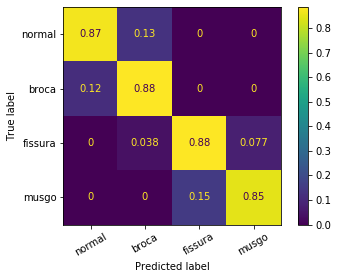

Rodada 1	-	Seed 2375
              precision    recall  f1-score   support

      normal       0.96      0.83      0.89        29
       broca       0.62      0.95      0.75        19
     fissura       0.84      0.70      0.76        30
       musgo       0.90      0.87      0.88        30

    accuracy                           0.82       108
   macro avg       0.83      0.84      0.82       108
weighted avg       0.85      0.82      0.83       108



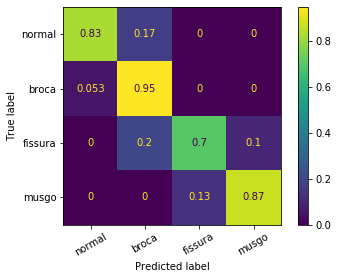

Rodada 2	-	Seed 3273
              precision    recall  f1-score   support

      normal       0.79      0.79      0.79        24
       broca       0.74      0.69      0.71        29
     fissura       0.85      0.88      0.87        26
       musgo       0.93      0.97      0.95        29

    accuracy                           0.83       108
   macro avg       0.83      0.83      0.83       108
weighted avg       0.83      0.83      0.83       108



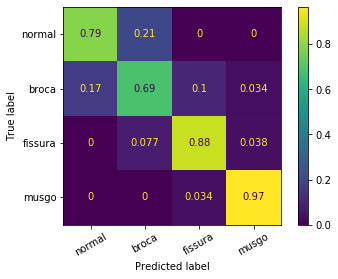

Rodada 3	-	Seed 4646
              precision    recall  f1-score   support

      normal       0.80      0.80      0.80        25
       broca       0.76      0.79      0.77        28
     fissura       0.96      0.85      0.90        27
       musgo       0.93      1.00      0.97        28

    accuracy                           0.86       108
   macro avg       0.86      0.86      0.86       108
weighted avg       0.86      0.86      0.86       108



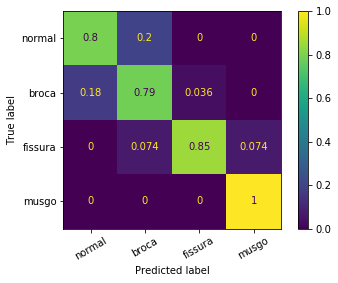

Rodada 4	-	Seed 6927
              precision    recall  f1-score   support

      normal       0.71      0.88      0.79        25
       broca       0.70      0.50      0.58        28
     fissura       0.76      0.87      0.81        30
       musgo       0.96      0.88      0.92        25

    accuracy                           0.78       108
   macro avg       0.78      0.78      0.77       108
weighted avg       0.78      0.78      0.77       108



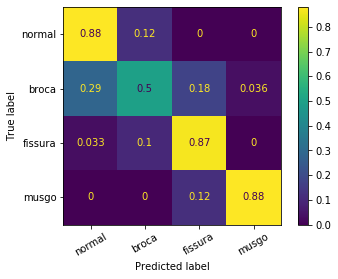

Rodada 5	-	Seed 2816
              precision    recall  f1-score   support

      normal       0.90      0.90      0.90        29
       broca       0.78      0.84      0.81        25
     fissura       0.79      0.81      0.80        27
       musgo       0.96      0.85      0.90        27

    accuracy                           0.85       108
   macro avg       0.85      0.85      0.85       108
weighted avg       0.86      0.85      0.85       108



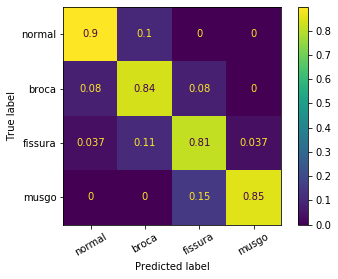

Rodada 6	-	Seed 4212
              precision    recall  f1-score   support

      normal       0.91      0.81      0.86        26
       broca       0.68      0.81      0.74        26
     fissura       0.68      0.79      0.73        24
       musgo       1.00      0.81      0.90        32

    accuracy                           0.81       108
   macro avg       0.82      0.80      0.81       108
weighted avg       0.83      0.81      0.81       108



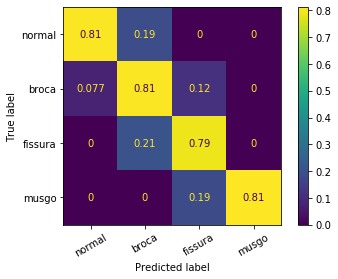

Rodada 7	-	Seed 2471
              precision    recall  f1-score   support

      normal       0.89      0.83      0.86        29
       broca       0.71      0.87      0.78        23
     fissura       0.75      0.88      0.81        24
       musgo       1.00      0.78      0.88        32

    accuracy                           0.83       108
   macro avg       0.84      0.84      0.83       108
weighted avg       0.85      0.83      0.84       108



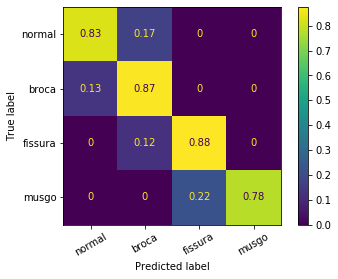

Rodada 8	-	Seed 7475
              precision    recall  f1-score   support

      normal       0.89      0.89      0.89        27
       broca       0.81      0.81      0.81        26
     fissura       0.92      0.81      0.86        27
       musgo       0.90      1.00      0.95        28

    accuracy                           0.88       108
   macro avg       0.88      0.88      0.88       108
weighted avg       0.88      0.88      0.88       108



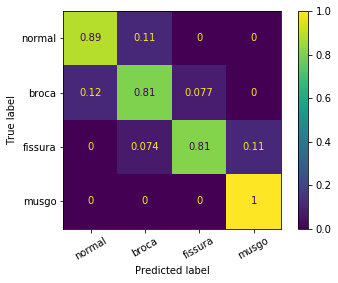

Rodada 9	-	Seed 5824
              precision    recall  f1-score   support

      normal       0.83      0.83      0.83        23
       broca       0.74      0.80      0.77        25
     fissura       0.81      0.85      0.83        34
       musgo       0.95      0.81      0.88        26

    accuracy                           0.82       108
   macro avg       0.83      0.82      0.82       108
weighted avg       0.83      0.82      0.83       108



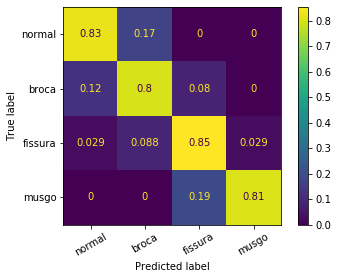

Rodada 10	-	Seed 1958
              precision    recall  f1-score   support

      normal       0.62      0.94      0.74        17
       broca       0.74      0.68      0.71        34
     fissura       0.82      0.72      0.77        32
       musgo       0.91      0.84      0.87        25

    accuracy                           0.77       108
   macro avg       0.77      0.79      0.77       108
weighted avg       0.79      0.77      0.77       108



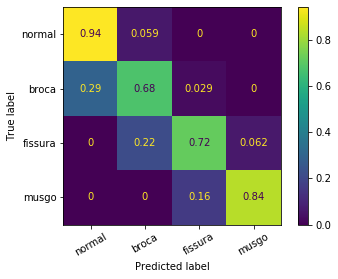

Rodada 11	-	Seed 2281
              precision    recall  f1-score   support

      normal       0.83      0.86      0.84        28
       broca       0.79      0.66      0.72        29
     fissura       0.73      0.96      0.83        25
       musgo       1.00      0.85      0.92        26

    accuracy                           0.82       108
   macro avg       0.84      0.83      0.83       108
weighted avg       0.84      0.82      0.82       108



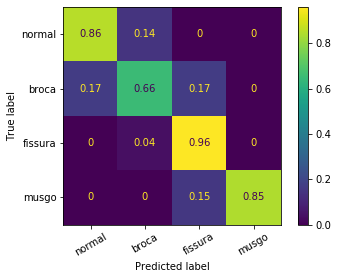

Rodada 12	-	Seed 6876
              precision    recall  f1-score   support

      normal       0.87      0.74      0.80        27
       broca       0.56      0.75      0.64        20
     fissura       0.77      0.79      0.78        29
       musgo       0.96      0.84      0.90        32

    accuracy                           0.79       108
   macro avg       0.79      0.78      0.78       108
weighted avg       0.81      0.79      0.79       108



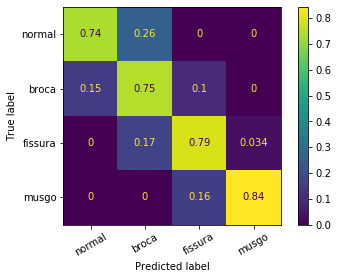

Rodada 13	-	Seed 353
              precision    recall  f1-score   support

      normal       1.00      0.83      0.91        30
       broca       0.77      0.96      0.86        25
     fissura       0.88      0.84      0.86        25
       musgo       0.93      0.93      0.93        28

    accuracy                           0.89       108
   macro avg       0.89      0.89      0.89       108
weighted avg       0.90      0.89      0.89       108



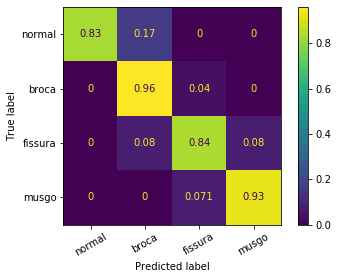

Rodada 14	-	Seed 6471
              precision    recall  f1-score   support

      normal       0.83      0.73      0.77        33
       broca       0.67      0.76      0.71        29
     fissura       0.83      0.80      0.82        25
       musgo       0.86      0.90      0.88        21

    accuracy                           0.79       108
   macro avg       0.80      0.80      0.80       108
weighted avg       0.79      0.79      0.79       108



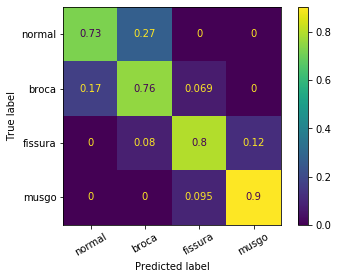

Rodada 15	-	Seed 2203
              precision    recall  f1-score   support

      normal       0.92      0.88      0.90        26
       broca       0.62      0.82      0.71        22
     fissura       0.76      0.63      0.69        30
       musgo       0.90      0.87      0.88        30

    accuracy                           0.80       108
   macro avg       0.80      0.80      0.80       108
weighted avg       0.81      0.80      0.80       108



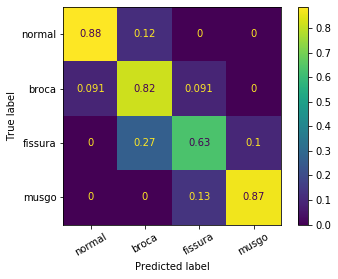

Rodada 16	-	Seed 62
              precision    recall  f1-score   support

      normal       0.82      0.79      0.81        29
       broca       0.67      0.80      0.73        20
     fissura       0.93      0.84      0.88        31
       musgo       0.93      0.93      0.93        28

    accuracy                           0.84       108
   macro avg       0.84      0.84      0.84       108
weighted avg       0.85      0.84      0.85       108



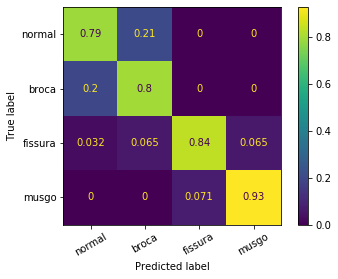

Rodada 17	-	Seed 2927
              precision    recall  f1-score   support

      normal       0.80      0.80      0.80        25
       broca       0.62      0.74      0.68        27
     fissura       0.91      0.71      0.80        28
       musgo       0.93      0.96      0.95        28

    accuracy                           0.81       108
   macro avg       0.82      0.80      0.81       108
weighted avg       0.82      0.81      0.81       108



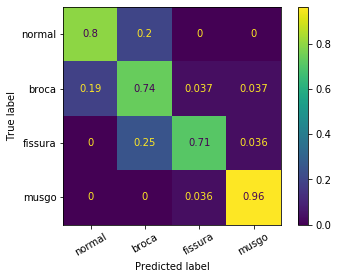

Rodada 18	-	Seed 4976
              precision    recall  f1-score   support

      normal       0.96      0.84      0.90        31
       broca       0.68      0.70      0.69        27
     fissura       0.76      0.73      0.75        30
       musgo       0.79      0.95      0.86        20

    accuracy                           0.80       108
   macro avg       0.80      0.81      0.80       108
weighted avg       0.80      0.80      0.80       108



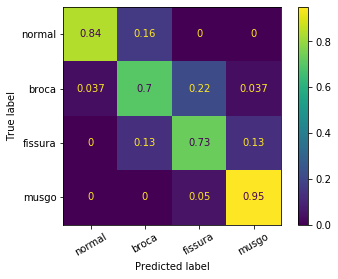

Rodada 19	-	Seed 7772
              precision    recall  f1-score   support

      normal       0.82      0.92      0.87        25
       broca       0.71      0.77      0.74        22
     fissura       0.77      0.71      0.74        28
       musgo       0.93      0.85      0.89        33

    accuracy                           0.81       108
   macro avg       0.81      0.81      0.81       108
weighted avg       0.82      0.81      0.82       108



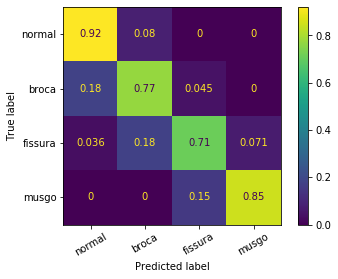

Rodada 20	-	Seed 297
              precision    recall  f1-score   support

      normal       0.94      0.83      0.88        35
       broca       0.77      0.85      0.81        27
     fissura       0.84      0.91      0.87        23
       musgo       0.95      0.91      0.93        23

    accuracy                           0.87       108
   macro avg       0.87      0.88      0.87       108
weighted avg       0.88      0.87      0.87       108



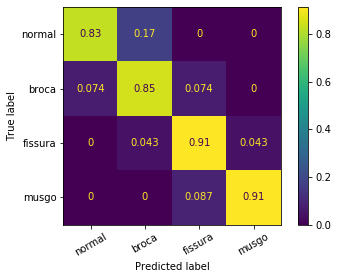

Rodada 21	-	Seed 5226
              precision    recall  f1-score   support

      normal       0.96      0.85      0.90        26
       broca       0.71      0.83      0.77        18
     fissura       0.76      0.81      0.78        31
       musgo       0.87      0.82      0.84        33

    accuracy                           0.82       108
   macro avg       0.82      0.83      0.82       108
weighted avg       0.83      0.82      0.83       108



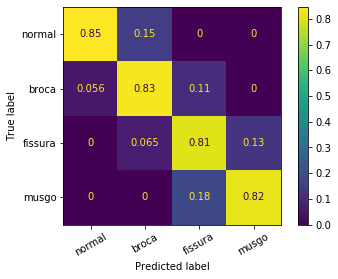

Rodada 22	-	Seed 3085
              precision    recall  f1-score   support

      normal       0.75      0.91      0.82        23
       broca       0.83      0.75      0.79        32
     fissura       0.81      0.78      0.79        27
       musgo       0.92      0.88      0.90        26

    accuracy                           0.82       108
   macro avg       0.83      0.83      0.83       108
weighted avg       0.83      0.82      0.82       108



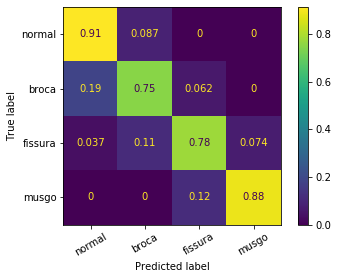

Rodada 23	-	Seed 5343
              precision    recall  f1-score   support

      normal       0.76      0.79      0.78        24
       broca       0.77      0.79      0.78        29
     fissura       0.86      0.83      0.84        29
       musgo       0.92      0.88      0.90        26

    accuracy                           0.82       108
   macro avg       0.83      0.82      0.82       108
weighted avg       0.83      0.82      0.82       108



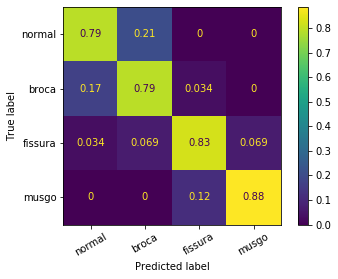

Rodada 24	-	Seed 3511
              precision    recall  f1-score   support

      normal       0.80      0.77      0.78        26
       broca       0.67      0.69      0.68        29
     fissura       0.86      0.78      0.82        32
       musgo       0.88      1.00      0.93        21

    accuracy                           0.80       108
   macro avg       0.80      0.81      0.80       108
weighted avg       0.80      0.80      0.80       108



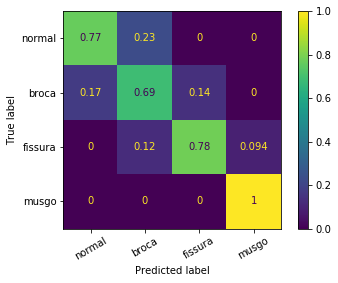

Rodada 25	-	Seed 7584
              precision    recall  f1-score   support

      normal       0.84      0.88      0.86        24
       broca       0.71      0.71      0.71        24
     fissura       0.83      0.83      0.83        30
       musgo       0.97      0.93      0.95        30

    accuracy                           0.84       108
   macro avg       0.84      0.84      0.84       108
weighted avg       0.84      0.84      0.84       108



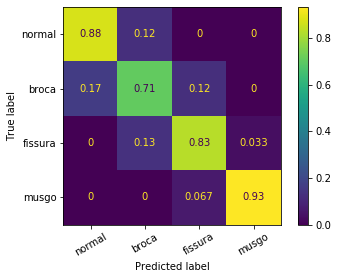

Rodada 26	-	Seed 6404
              precision    recall  f1-score   support

      normal       0.91      0.91      0.91        23
       broca       0.81      0.92      0.86        24
     fissura       0.88      0.91      0.89        32
       musgo       1.00      0.86      0.93        29

    accuracy                           0.90       108
   macro avg       0.90      0.90      0.90       108
weighted avg       0.90      0.90      0.90       108



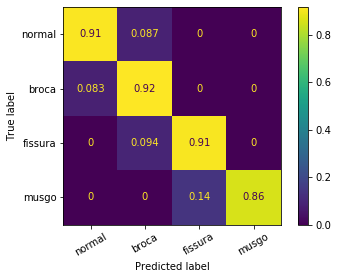

Rodada 27	-	Seed 4813
              precision    recall  f1-score   support

      normal       0.90      0.93      0.92        30
       broca       0.61      0.85      0.71        20
     fissura       0.85      0.66      0.74        35
       musgo       0.86      0.83      0.84        23

    accuracy                           0.81       108
   macro avg       0.81      0.82      0.80       108
weighted avg       0.82      0.81      0.81       108



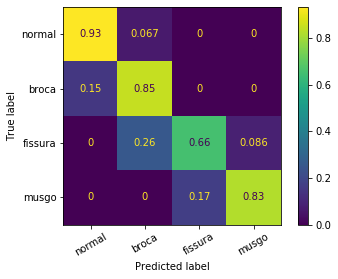

Rodada 28	-	Seed 4377
              precision    recall  f1-score   support

      normal       0.93      0.90      0.91        29
       broca       0.79      0.88      0.84        26
     fissura       0.91      0.78      0.84        27
       musgo       0.86      0.92      0.89        26

    accuracy                           0.87       108
   macro avg       0.87      0.87      0.87       108
weighted avg       0.87      0.87      0.87       108



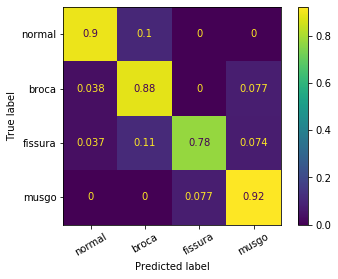

Rodada 29	-	Seed 3288
              precision    recall  f1-score   support

      normal       0.82      0.78      0.80        23
       broca       0.67      0.88      0.76        25
     fissura       0.89      0.74      0.81        34
       musgo       0.92      0.88      0.90        26

    accuracy                           0.81       108
   macro avg       0.82      0.82      0.82       108
weighted avg       0.83      0.81      0.82       108



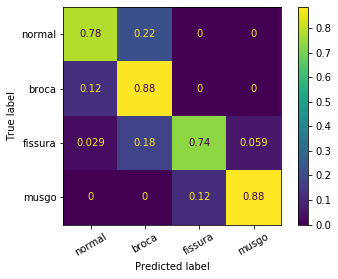

In [4]:
df = pd.read_csv('./csvs/otsu_lbp_norm3_toras.csv')
y = df.pop('target').values
X = df.values

# Gerando 30 sementes "aleatórias" dentro do intervalo [0, 8000)
seed_arr = np.random.randint(8000, size=30)

acc_e_f1_por_rodada = []
confu_matrices = []

for rodada, seed in enumerate(seed_arr):
  # separando dados
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

  clf = make_pipeline(StandardScaler(), SVC()).fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  
  # Adicionando resultados à respectiva lista
  acc_e_f1_por_rodada.append(
    [accuracy_score(y_test, y_pred)]
    + list(f1_score(y_test, y_pred, average=None)))

  confu_matrices.append(
    confusion_matrix(y_test, y_pred, normalize='true'))

  print(f'Rodada {rodada}\t-\tSeed {seed}')
  print(
    classification_report(
      y_true=y_test,
      y_pred=y_pred,
      target_names=TARGET_NAMES))

  plot_confusion_matrix(
    estimator=clf,
    X=X_test,
    y_true=y_test,
    display_labels=TARGET_NAMES,
    xticks_rotation=30,
    normalize='true')
  
  plt.show()

## Métricas do experimento

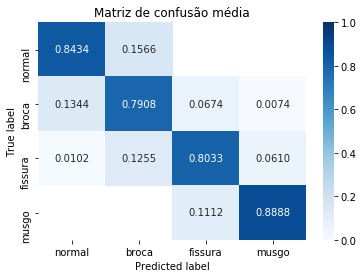

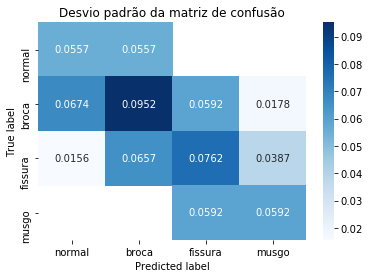

In [5]:
confusion_matrix_mean = np.mean(confu_matrices, axis=0)
confusion_matrix_std = np.std(confu_matrices, axis=0)

sns.heatmap(
    data=confusion_matrix_mean,
    cmap='Blues',
    vmin=0,
    vmax=1,
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_mean == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Matriz de confusão média',
        xlabel='Predicted label',
        ylabel='True label')

plt.show()

sns.heatmap(
    data=confusion_matrix_std,
    cmap='Blues',
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_std == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Desvio padrão da matriz de confusão',
        xlabel='Predicted label',
        ylabel='True label')

None

        Acurácia  f1-normal   f1-broca  f1-fissura   f1-musgo
count  30.000000  30.000000  30.000000   30.000000  30.000000
mean    0.828086   0.845509   0.748645    0.811944   0.904664
std     0.033841   0.051508   0.065982    0.051906   0.031576
min     0.768519   0.744186   0.583333    0.690909   0.843750
25%     0.805556   0.800000   0.708333    0.780058   0.881947
50%     0.824074   0.857143   0.744565    0.814413   0.901961
75%     0.849537   0.894636   0.786242    0.849415   0.928571
max     0.898148   0.918033   0.867925    0.901961   0.965517


Acurácia,f1-normal,f1-broca,f1-fissura,f1-musgo
0.870370,0.869565,0.867925,0.851852,0.888889
0.824074,0.888889,0.750000,0.763636,0.881356
0.833333,0.791667,0.714286,0.867925,0.949153
0.861111,0.800000,0.771930,0.901961,0.965517
0.777778,0.785714,0.583333,0.812500,0.916667
0.851852,0.896552,0.807692,0.800000,0.901961
0.805556,0.857143,0.736842,0.730769,0.896552
0.833333,0.857143,0.784314,0.807692,0.877193
0.879630,0.888889,0.807692,0.862745,0.949153
0.824074,0.826087,0.769231,0.828571,0.875000


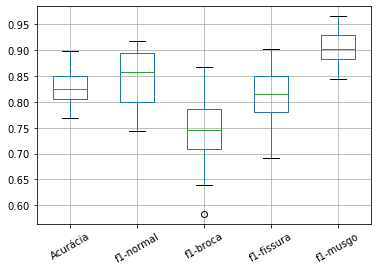

In [6]:
acc_df = pd.DataFrame(
  data=acc_e_f1_por_rodada,
  columns=['Acurácia'] + [f'f1-{name}' for name in TARGET_NAMES])

print(acc_df.describe())

acc_df.boxplot(rot=30)

acc_df.style.hide_index().background_gradient(cmap='Blues')